In [1]:
import scipy
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
from ppg.common import config
from ppg.common.utils import load_data
from ppg.enums import DataColumn, WavelengthIndex

In [3]:
ts1 = load_data('ppg_curve_0.nc')
ts2 = load_data('ppg_curve_1.nc')

In [4]:
# sampling frequency
Fs = 100
Tstep = 1 / Fs

# number of samples
N = len(ts1[DataColumn.TIME])
Fstep = Fs / N

In [5]:
# DC offset
# To provide more intuitive FFT analysis, let's get rid of DC component
# Firstly suppose DC component/offset as constant/linear - not varying in time so much - and compute it as mean of time series
# This is just for now, to see raw frequency spectrum
# According to outcomes, we will decide how to setup band-pass filter
# Band-pass filter would remove LF offset and HF noise
ts1_without_mean_offset = ts1[DataColumn.PPG_CURVE] - np.mean(ts1[DataColumn.PPG_CURVE], axis=1)[:, None]

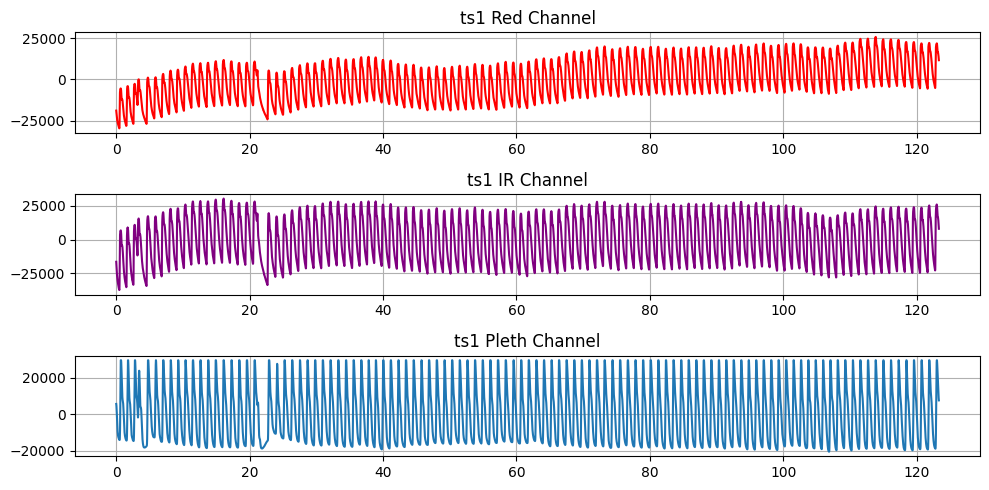

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_mean_offset[WavelengthIndex.RED], color='red')
plt.title('ts1 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_mean_offset[WavelengthIndex.IR], color='purple')
plt.title('ts1 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_mean_offset[WavelengthIndex.PLETH])
plt.title('ts1 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

In [21]:
pd.DataFrame(ts1[DataColumn.PPG_CURVE][WavelengthIndex.RED]).diff()

,0
0,NaN
1,-447.0
2,-523.0
3,-503.0
4,-534.0
...,...
12328,-459.0
12329,-470.0
12330,-436.0
12331,-487.0


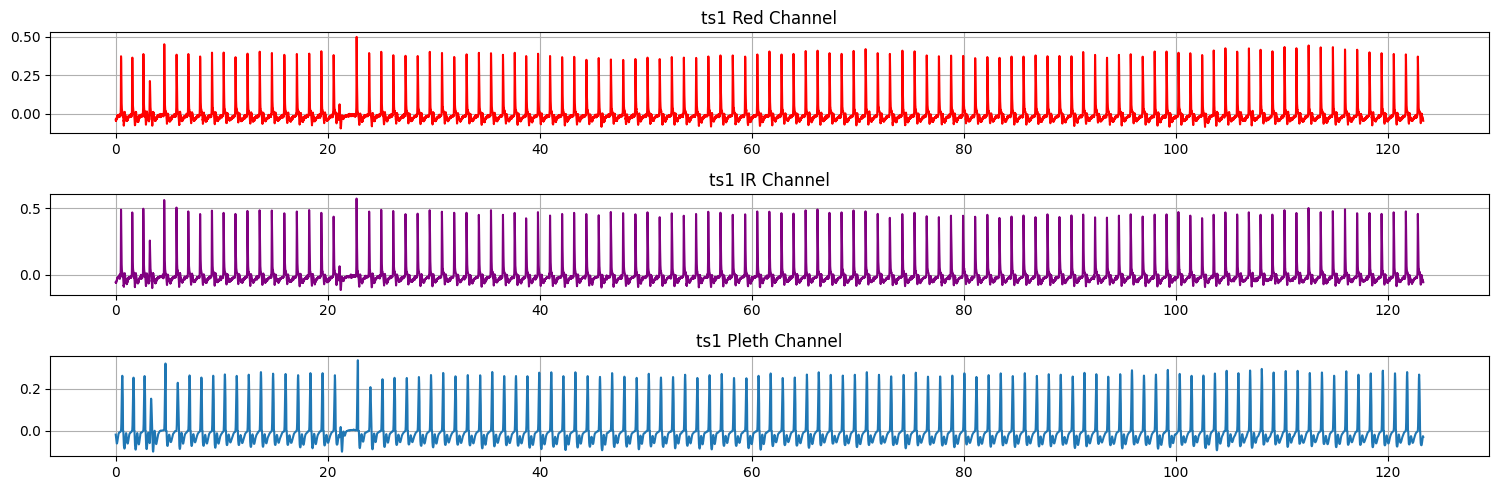

In [34]:
from ppg.processing.normalization import ZscoreNormalization

# First Difference analysis
a = ZscoreNormalization().process(ts1[DataColumn.PPG_CURVE][:])
ts1_without_first_diff = pd.DataFrame(a).diff(axis=1).values

plt.figure(figsize=(15,5))

plt.subplot(3,1,1)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_first_diff[WavelengthIndex.RED], color='red')
plt.title('ts1 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_first_diff[WavelengthIndex.IR], color='purple')
plt.title('ts1 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_first_diff[WavelengthIndex.PLETH])
plt.title('ts1 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

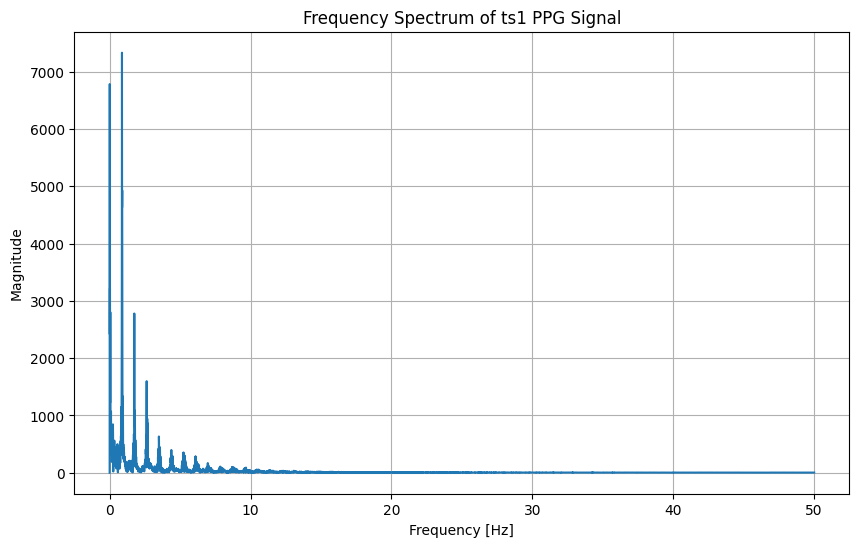

In [217]:
# FFT analysis - Discrete Fourier Transform
fy = scipy.fft.fft(ts1_without_mean_offset[WavelengthIndex.RED])

# Since sampling frequency Fs is 100Hz, according to Nyquist–Shannon sampling theorem we will analyse frequencies no greater than Fs/2.0 = 50Hz
# Additionally we will consider only 1. half of result, since the second half is basically just complex conjugate of the first half -> N//2
fx = np.linspace(0.0, Fs/2.0, N//2)
fy = np.abs(fy[:N//2])


plt.figure(figsize=(10, 6))
plt.plot(fx, 2.0/N * fy)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of ts1 PPG Signal')
plt.grid()
plt.show()

In [218]:
# According to Frequency spectrum, there is till DC offset component present, with frequency close to zero
# There are no really significant High-frequency nosies. Since sampling frequency is relatively low. On hardware level, electric devices cause much higher noises - in kHz units.
# I guess, Low-pass filter would be enough and more important.
# We need to precisely select Low cut-off frequency!

# We definitely need to keep heartbeat frequency in full range.
# consider minimal frequency for athletes in calm conditions 40BPM -> 0.67 Hz
# let's choose cut-off frequency smaller than 0.67Hz

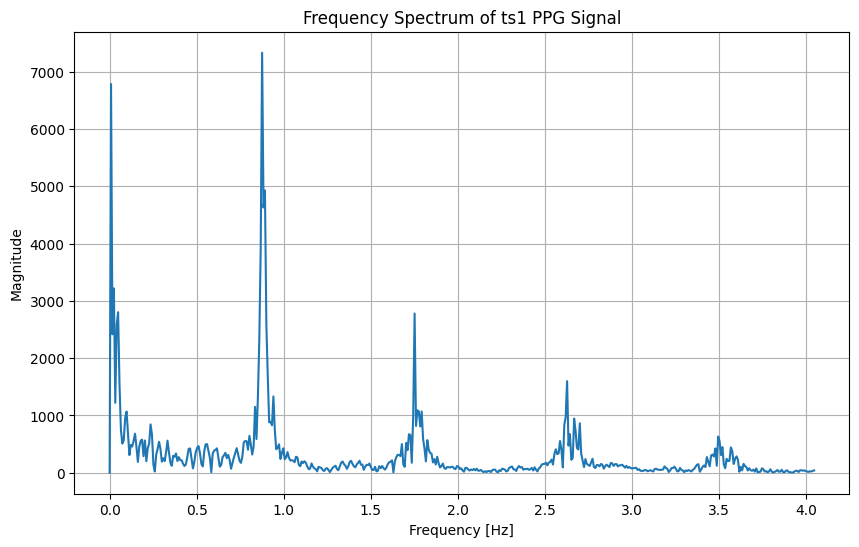

In [250]:
# Zoom-in on frequency spectrum to confirm assumptions
plt.figure(figsize=(10, 6))
plt.plot(fx[0:500], 2.0/N * fy[0:500])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of ts1 PPG Signal')
plt.grid()
plt.show()

In [235]:
# I would like to see exact value of top 10 peaks in frequency spectrum
peaks, _ = signal.find_peaks(fy)
top_10_peaks_indices = peaks[np.argsort(fy[peaks])[-10:]]

f_peaks = pd.DataFrame({'magnitude': fy[top_10_peaks_indices], 'frequency': fx[top_10_peaks_indices]})
f_peaks

,magnitude,frequency
0,6.717960e+06,1.768045
1,7.081919e+06,0.835361
2,8.207830e+06,0.940795
3,9.854119e+06,2.627737
4,1.713383e+07,1.751825
5,1.727694e+07,0.048662
6,1.983919e+07,0.024331
7,3.038029e+07,0.892133
8,4.182770e+07,0.008110
9,4.520035e+07,0.875912


In [248]:
# Compute HeartBeat as the value of the highest peak
ts1_heart_beat = f_peaks.sort_values('magnitude', ascending=False).iloc[0].frequency * 60
ts1_heart_beat

52.55474452554744

In [ ]:
# Frequencies [0.0081103 , 0.0243309 , 0.0486618] would be part of DC component, but it can also be somthing I am missing in medical understanding
# The heartbeat of ts1 is approximately 0.87 Hz -> 52.55 BPM

In [ ]:
# Considering breathing rate, as it would be present in frequency spectrogram reaching low frequencies
# The average breathing rate for adult at rest is 0.1 - 0.4 Hz,  while muscles work harder, breathing rate can reach 1Hz or even more
# Let's assume, if there is significant magnitude in breathing frequency range -  we are detecting breathing process
# unfortunately I don't see such peak, but at least, we will consider it in Low-pass filter adjustment. (it may be frequency close to heart-beat, as there are multiple peaks)
# Finally, let's choose cut-off frequency 0.05, since the breathing will be at higher frequency.

In [287]:
# Advanced DC offset filtering using Butterworth HIGH-PASS filter
CUT_OFF = 0.05
b, a = signal.butter(5, CUT_OFF, btype='highpass', fs=Fs)
ts1_without_low_frequency_offset = signal.filtfilt(b, a, ts1[DataColumn.PPG_CURVE])

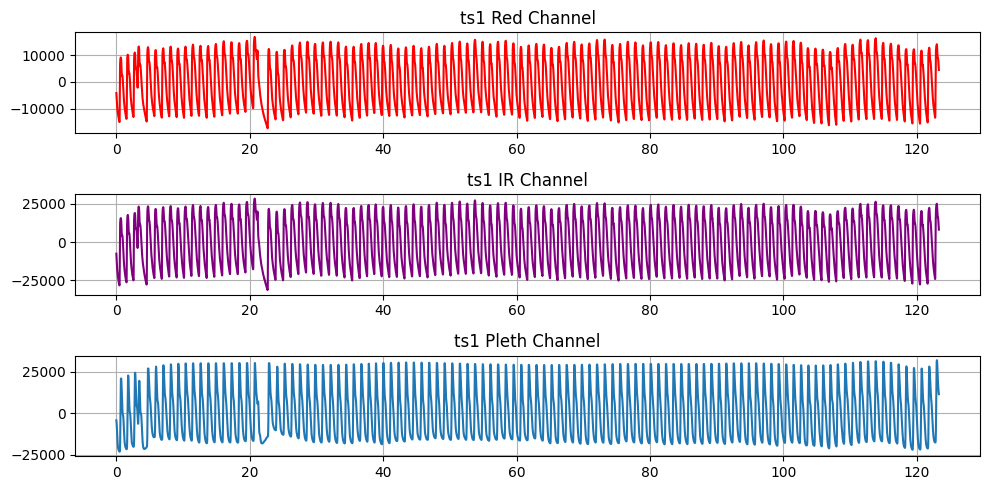

In [288]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_low_frequency_offset[WavelengthIndex.RED], color='red')
plt.title('ts1 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_low_frequency_offset[WavelengthIndex.IR], color='purple')
plt.title('ts1 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ts1[DataColumn.TIME][:], ts1_without_low_frequency_offset[WavelengthIndex.PLETH])
plt.title('ts1 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

In [253]:
# High-pass outcomes looks much better. But to be sure we don't damage the shape of waves, let's visually check and compare graphs with original plots in visualisation.ipynb

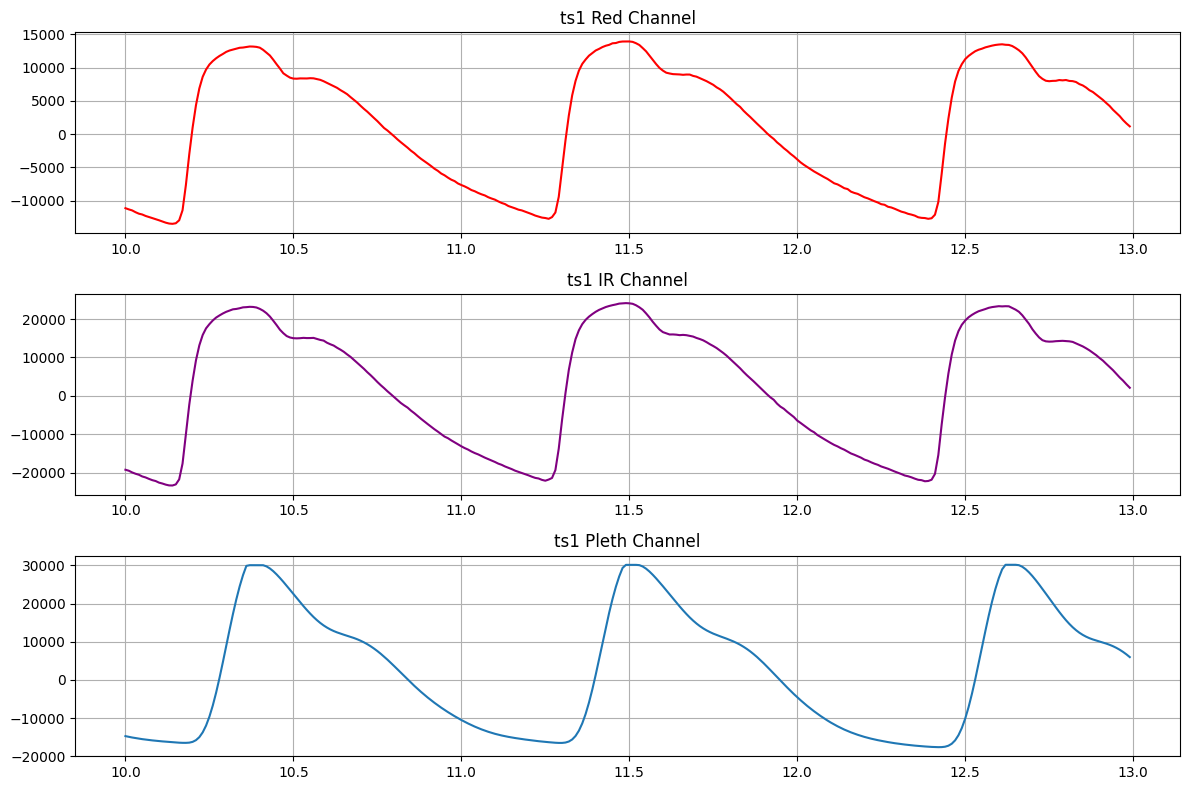

In [254]:
plt.figure(figsize=(12,8))

START = 1000
END = 1300

plt.subplot(3,1,1)
plt.plot(ts1[DataColumn.TIME][START:END], ts1_without_low_frequency_offset[WavelengthIndex.RED][START:END], color='red')
plt.title('ts1 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ts1[DataColumn.TIME][START:END], ts1_without_low_frequency_offset[WavelengthIndex.IR][START:END], color='purple')
plt.title('ts1 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ts1[DataColumn.TIME][START:END], ts1_without_low_frequency_offset[WavelengthIndex.PLETH][START:END])
plt.title('ts1 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

In [255]:
# According to visual inspection, the shape of waves looks as original. It is OK

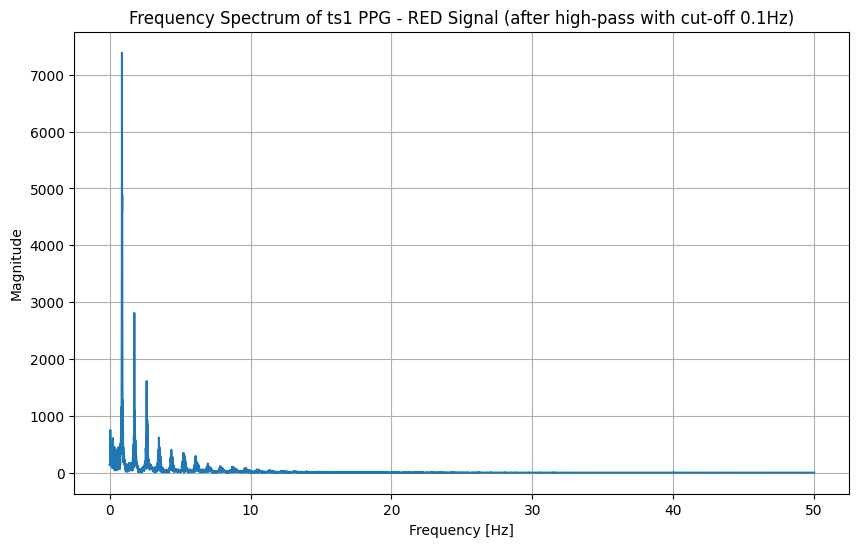

In [258]:
# FFT analysis - Discrete Fourier Transform
fy = scipy.fft.fft(ts1_without_low_frequency_offset[WavelengthIndex.RED])

# Since sampling frequency Fs is 100Hz, according to Nyquist–Shannon sampling theorem we will analyse frequencies no greater than Fs/2.0 = 50Hz
# Additionally we will consider only 1. half of result, since the second half is basically just complex conjugate of the first half -> N//2
fx = np.linspace(0.0, Fs/2.0, N//2)
fy = np.abs(fy[:N//2])


plt.figure(figsize=(10, 6))
plt.plot(fx, 2.0/N * fy)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of ts1 PPG - RED Signal (after high-pass with cut-off 0.05Hz)')
plt.grid()
plt.show()

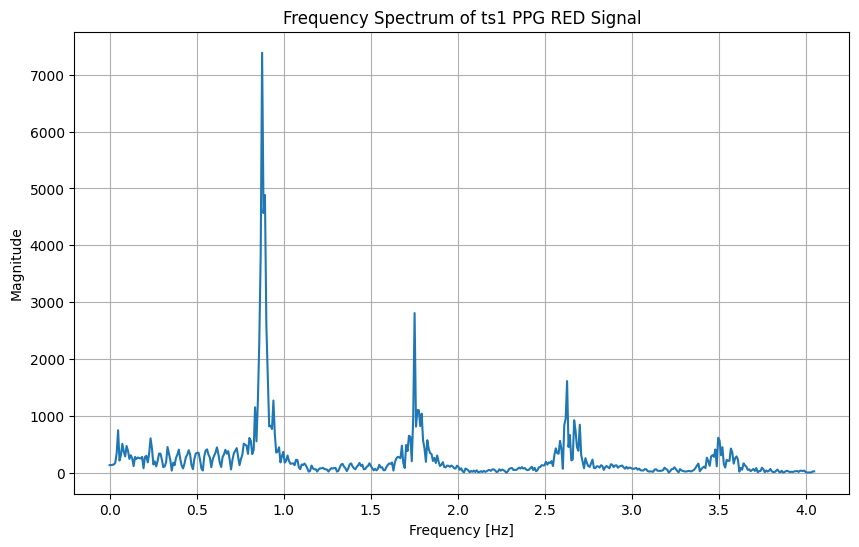

In [259]:
# Zoom-in on frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(fx[0:500], 2.0/N * fy[0:500])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of ts1 PPG RED Signal')
plt.grid()
plt.show()

In [ ]:
# Breathing rate is still not visible, but maybe it will be more significant in ts2 conditions

In [260]:
# Analysis of ts2
# From initial data visualisation, I except higher heart beat rate -  and so more dynamic conditions

In [261]:
ts2_without_mean_offset = ts2[DataColumn.PPG_CURVE] - np.mean(ts2[DataColumn.PPG_CURVE], axis=1)[:, None]

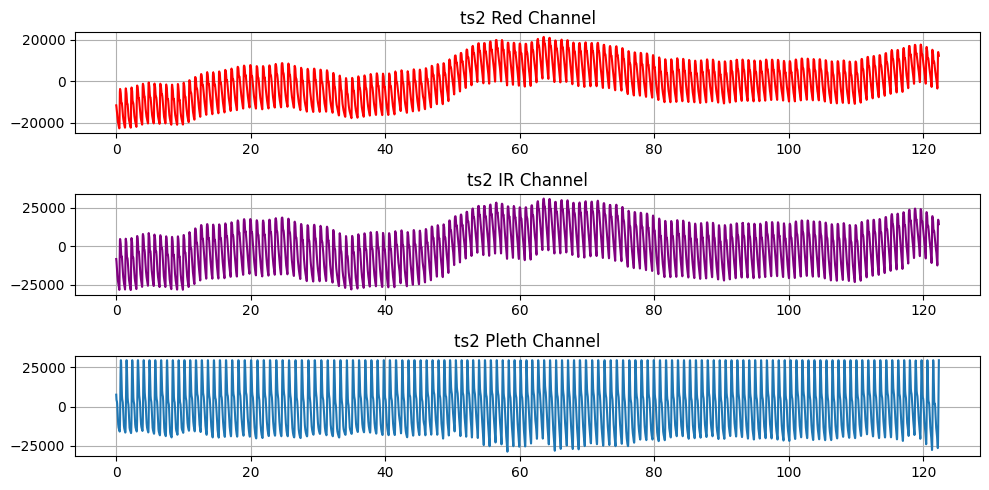

In [263]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_mean_offset[WavelengthIndex.RED], color='red')
plt.title('ts2 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_mean_offset[WavelengthIndex.IR], color='purple')
plt.title('ts2 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_mean_offset[WavelengthIndex.PLETH])
plt.title('ts2 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

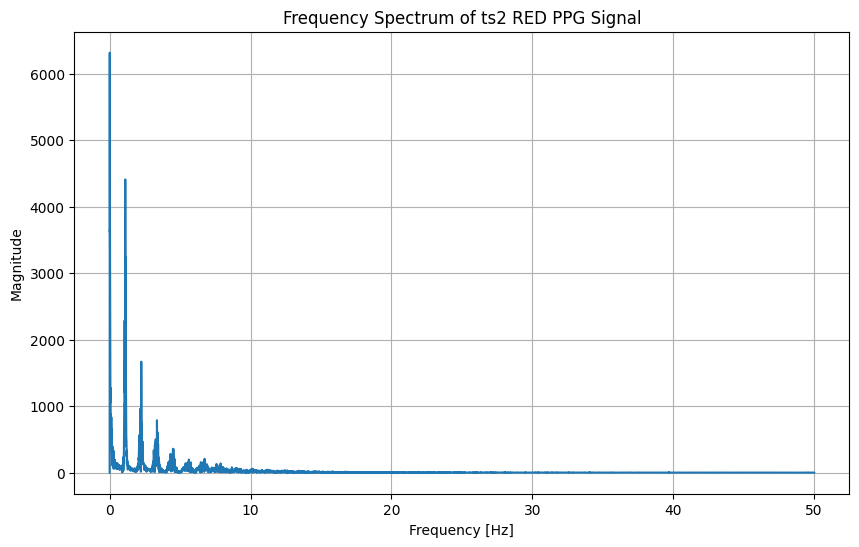

In [267]:
# FFT analysis - Discrete Fourier Transform
fy = scipy.fft.fft(ts2_without_mean_offset[WavelengthIndex.RED])

fx = np.linspace(0.0, Fs/2.0, N//2)
fy = np.abs(fy[:N//2])

plt.figure(figsize=(10, 6))
plt.plot(fx, 2.0/N * fy)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of ts2 RED PPG Signal')
plt.grid()
plt.show()

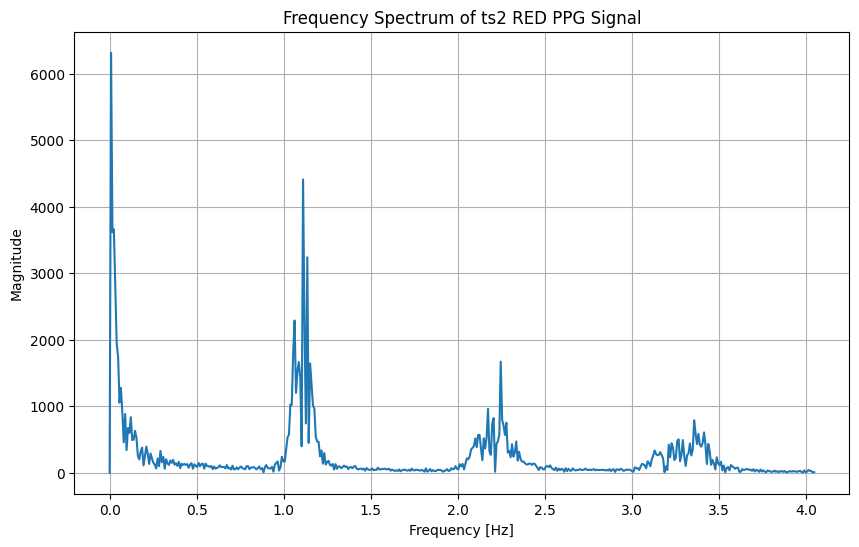

In [269]:
plt.figure(figsize=(10, 6))
plt.plot(fx[0:500], 2.0/N * fy[0:500])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of ts2 RED PPG Signal')
plt.grid()
plt.show()

In [270]:
 # Heart beat is definitely higher > 1.0Hz and the signal is spectrum is more peaky
# Let's apply High-Pass filter

In [581]:
CUT_OFF = 0.05
b, a = signal.butter(5, Wn=CUT_OFF, btype='highpass', fs=Fs)
ts2_without_low_frequency_offset = signal.filtfilt(b, a, ts2[DataColumn.PPG_CURVE])

len(a), len(b)

(6, 6)

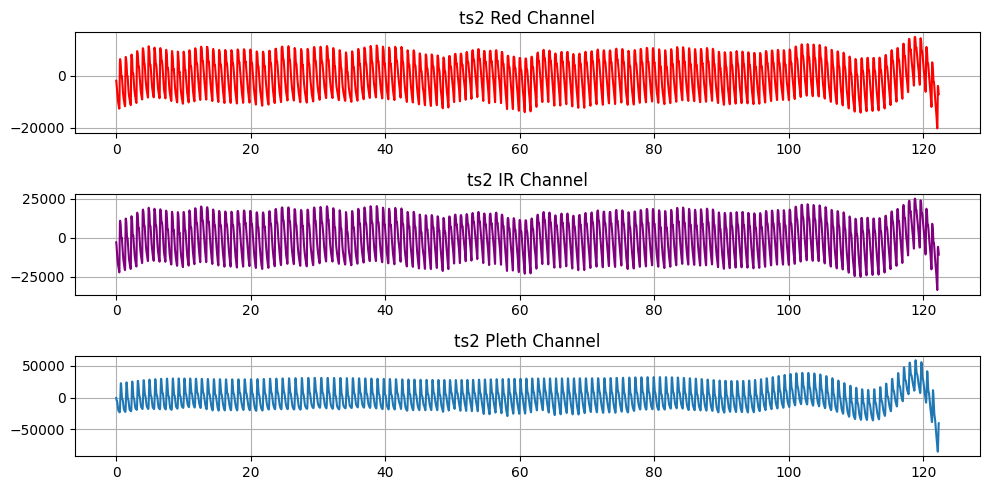

In [582]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_low_frequency_offset[WavelengthIndex.RED], color='red')
plt.title('ts2 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_low_frequency_offset[WavelengthIndex.IR], color='purple')
plt.title('ts2 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_low_frequency_offset[WavelengthIndex.PLETH])
plt.title('ts2 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

In [583]:
# Second time series contains low frequency DC offset at the end, which wasn't filtered by High-Pass. Definitely unwanted behavior.
# After researching, I found it is called the Ringing effect or Gibbs phenomenon.
# Let's address it using padding.

b, a = signal.butter(5, Wn=CUT_OFF, btype='highpass', fs=Fs)

PADDING_SIZE = 1000

ts2_without_low_frequency_offset = []

for index in range(len(ts2[DataColumn.PPG_CURVE][:])):
    data = ts2[DataColumn.PPG_CURVE][index]

    pre_padding = data[:PADDING_SIZE][::-1]
    post_padding = data[-PADDING_SIZE:][::-1]

    data = np.concatenate((pre_padding, data, post_padding))
    data = signal.filtfilt(b, a, data, padlen=0)[PADDING_SIZE:-PADDING_SIZE]

    ts2_without_low_frequency_offset.append(data)

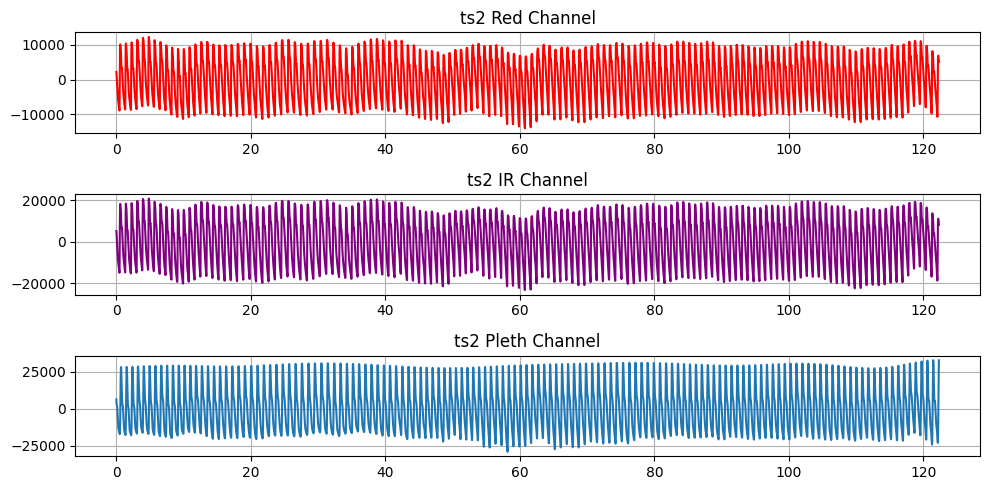

In [584]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_low_frequency_offset[WavelengthIndex.RED], color='red')
plt.title('ts2 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_low_frequency_offset[WavelengthIndex.IR], color='purple')
plt.title('ts2 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ts2[DataColumn.TIME][:], ts2_without_low_frequency_offset[WavelengthIndex.PLETH])
plt.title('ts2 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
# Wow, it works.

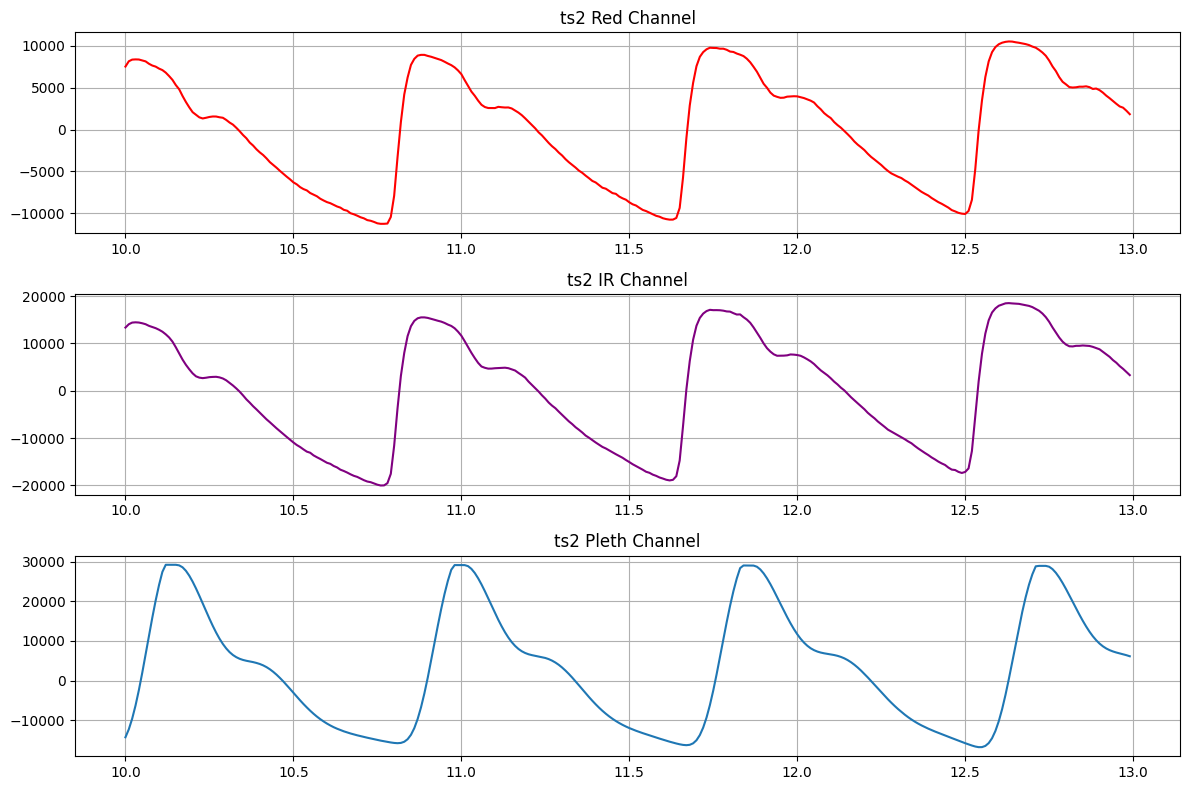

In [454]:
plt.figure(figsize=(12,8))

START = 1000
END = 1300

plt.subplot(3,1,1)
plt.plot(ts2[DataColumn.TIME][START:END], ts2_without_low_frequency_offset[WavelengthIndex.RED][START:END], color='red')
plt.title('ts2 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ts2[DataColumn.TIME][START:END], ts2_without_low_frequency_offset[WavelengthIndex.IR][START:END], color='purple')
plt.title('ts2 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ts2[DataColumn.TIME][START:END], ts2_without_low_frequency_offset[WavelengthIndex.PLETH][START:END])
plt.title('ts2 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

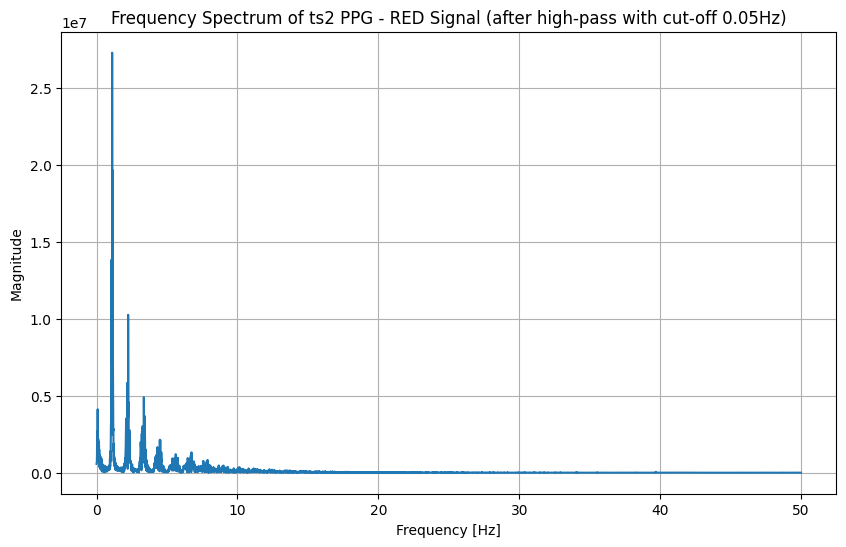

In [484]:
# FFT analysis - Discrete Fourier Transform
fy = scipy.fft.fft(ts2_without_low_frequency_offset[WavelengthIndex.RED])

fx = np.linspace(0.0, Fs/2.0, N//2)
fy = np.abs(fy[:N//2])


plt.figure(figsize=(10, 6))
plt.plot(fx, fy)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of ts2 PPG - RED Signal (after high-pass with cut-off 0.05Hz)')
plt.grid()
plt.show()

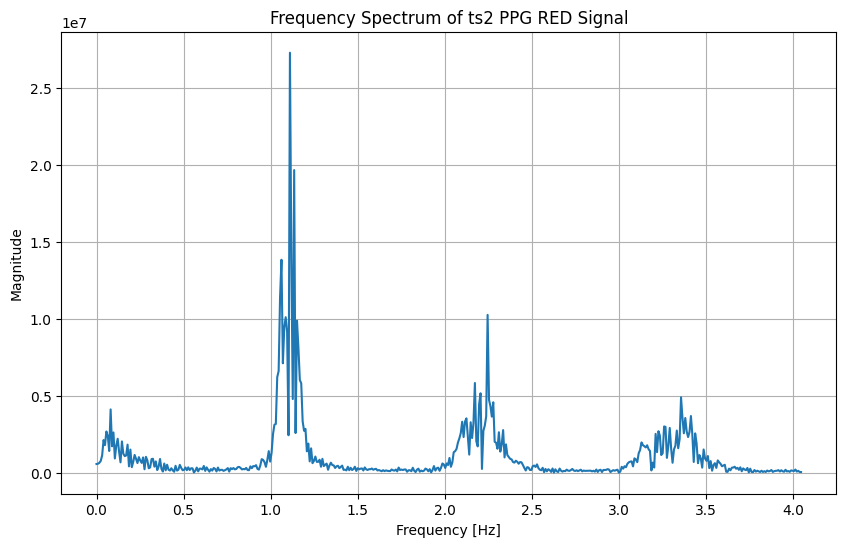

In [483]:
# Zoom-in on frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(fx[0:500], fy[0:500])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of ts2 PPG RED Signal')
plt.grid()
plt.show()

In [482]:
peaks, _ = signal.find_peaks(fy)
top_10_peaks_indices = peaks[np.argsort(fy[peaks])[-10:]]

f_peaks = pd.DataFrame({'magnitude': fy[top_10_peaks_indices], 'frequency': fx[top_10_peaks_indices]})
f_peaks

,magnitude,frequency
0,4.588888e+06,2.278994
1,4.912667e+06,3.357664
2,5.173417e+06,2.206002
3,5.842161e+06,2.173560
4,9.889880e+06,1.151663
5,1.011943e+07,1.086780
6,1.027119e+07,2.246553
7,1.385611e+07,1.062449
8,1.968568e+07,1.135442
9,2.731639e+07,1.111111


In [485]:
ts2_heart_beat = f_peaks.sort_values('magnitude', ascending=False).iloc[0].frequency * 60
ts2_heart_beat

66.66666666666666

In [491]:
# PPG data Peak-to-peak analysis
# Average peak-to-peak should correlate with heartbeat obtained from FFT

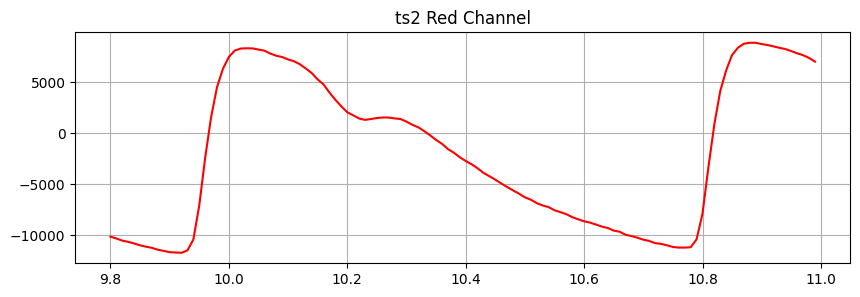

In [509]:
plt.figure(figsize=(10,3))
plt.subplot(1,1,1)
START = 980
END = 1100
plt.plot(ts2[DataColumn.TIME][START:END], ts2_without_low_frequency_offset[WavelengthIndex.RED][START:END], color='red')
plt.title('ts2 Red Channel')
plt.grid()

In [ ]:
# PTP time should be cca 0.9

In [535]:
peaks, _ = signal.find_peaks(ts2_without_low_frequency_offset[WavelengthIndex.RED], distance=40)
peak_to_peak_times = np.diff(ts2[DataColumn.TIME][peaks])
np.mean(peak_to_peak_times)

0.8944117647058825